# Regularization

In [38]:
!pip install pandas
!pip install numpy
!pip install opencv-python
!pip install scipy
!pip install matplotlib

In [39]:
import pandas as pd
import numpy as np
import cv2
from scipy.interpolate import UnivariateSpline, interp1d
import matplotlib.pyplot as plt
from image2polyline import extract_pixel_data

In [40]:
# Smoothing function
def smooth_points(x, y, s=0):
    spline_x = UnivariateSpline(range(len(x)), x, s=s)
    spline_y = UnivariateSpline(range(len(y)), y, s=s)
    return spline_x(range(len(x))), spline_y(range(len(y)))

In [41]:
# Interpolation function
def interpolate_points(x, y, num_points):
    t = np.linspace(0, 1, len(x))
    f_x = interp1d(t, x, kind='linear')
    f_y = interp1d(t, y, kind='linear')
    t_new = np.linspace(0, 1, num_points)
    return f_x(t_new), f_y(t_new)

In [42]:
def points_to_image(points, width=1000, height=1000):
    img = np.zeros((height, width), dtype=np.uint8)
    for x, y in points:
        if 0 <= int(y) < height and 0 <= int(x) < width:
            img[int(y), int(x)] = 255
    return img

In [43]:
def detect_shapes(img):
    shapes = []
    edges = cv2.Canny(img.copy(), 0, 50)
    edges_line = cv2.GaussianBlur(edges.copy(), (15, 15), 0)

    lines = cv2.HoughLinesP(edges_line, 1, np.pi / 2, threshold=200, minLineLength=0, maxLineGap=100)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                shapes.append(("Line", np.array([[x1, y1], [x2, y2]])))

    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 500:
            continue

        epsilon = 0.03 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        area1 = cv2.contourArea(approx)
        area2 = cv2.contourArea(contour)

        if len(approx) == 3:
            shapes.append(("Triangle", approx))
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            shape = "Square" if 0.85 <= aspect_ratio <= 1.15 else "Rectangle"
            shapes.append((shape, approx))
        elif len(approx) > 4:
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circularity = area / (np.pi * radius * radius)
            if 0.70 <= circularity <= 1.3:
                center = (int(x), int(y))
                radius = int(radius)
                shapes.append(("Circle", (center, radius)))
            else:
                if 1.05 * area2 >= area1 >= 0.95 * area2:
                    shapes.append(("Polygon", approx))

            if len(approx) >= 6:
                ellipse = cv2.fitEllipse(contour)
                center, axes, angle = ellipse
                axes = (int(axes[0] / 2), int(axes[1] / 2))
                ellipse_contour = cv2.ellipse2Poly(
                    center=(int(center[0]), int(center[1])),
                    axes=axes,
                    angle=int(angle),
                    arcStart=0,
                    arcEnd=360,
                    delta=5
                )
                ellipse_contour = np.array(ellipse_contour)
                distance = cv2.pointPolygonTest(ellipse_contour, center, True)
                if abs(distance) < 40:
                    shapes.append(("Ellipse", ellipse_contour))

            if len(approx) == 10:
                shapes.append(("Star", approx))

    shape_priorities = {"Circle": 1, "Square": 2, "Rectangle": 3, "Triangle": 4, "Ellipse": 5,"Star": 6, "Polygon": 7,
                        "Line": 8}

    if shapes:
        shapes = sorted(shapes, key=lambda s: shape_priorities.get(s[0], 9))
        most_probable_shape = shapes[0]
        return [most_probable_shape]

    return shapes

In [44]:
def draw_shapes(img, shapes, curve_points=None):
    if len(img.shape) == 2:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_color = img.copy()

    blank_image = np.zeros_like(img_color)
    shape_coords = []

    if shapes:
        for shape, contour in shapes:
            color = (255, 255, 255)  # White

            if shape == "Circle":
                center, radius = contour
                # Generate points for the circle
                num_points = 100
                angle = np.linspace(0, 2 * np.pi, num_points)
                circle_points = np.array([
                    (int(center[0] + radius * np.cos(a)), int(center[1] + radius * np.sin(a)))
                    for a in angle
                ])
                cv2.polylines(blank_image, [circle_points], isClosed=True, color=color, thickness=1)
                shape_coords.append(("Circle", circle_points))
            else:
                cv2.drawContours(blank_image, [contour], -1, color, 1)
                coords = contour.squeeze()
                shape_coords.append((shape, coords))
    else:
        if curve_points is not None:
            color = (255, 255, 255)  # White
            cv2.polylines(blank_image, [curve_points], isClosed=False, color=color, thickness=1)
            shape_coords.append(("Curve", curve_points))

    return blank_image, shape_coords

In [45]:
def combine_images(images, positions, width=1000, height=1000):
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    for img, (x, y) in zip(images, positions):
        h, w = img.shape[:2]
        x = max(0, min(x, width - w))
        y = max(0, min(y, height - h))
        mask = img != 0
        combined_image[y:y + h, x:x + w][mask] = img[mask]
    return combined_image

In [46]:
def execute(csv_path):
    df = pd.read_csv(f"../trash/tc/{csv_path}.csv", header=None, names=['Curve', 'Shape', 'X', 'Y'])
    # Initialize lists for storing results
    processed_curves = []
    images = []
    positions = []
    output_data = []
    
    # Group by curve
    curves = df.groupby(['Curve', 'Shape'])
    
    for curve_id, group in curves:
        x, y = group['X'].values, group['Y'].values
        x_smooth, y_smooth = smooth_points(x, y, s=0)
        x_interp, y_interp = interpolate_points(x_smooth, y_smooth, num_points=1000)
    
        pos_x, pos_y = int(x.min()), int(y.min())
        points = np.vstack((x_interp, y_interp)).T
        positions.append((int(x.min()), int(y.min())))
    
        img = points_to_image(points)
        shapes = detect_shapes(img)
    
        img_with_shapes, shape_coords = draw_shapes(img, shapes, curve_points=np.int32(points))
        images.append(img_with_shapes)
    
        # Store shape coordinates
        for shape_type, coords in shape_coords:
            if shape_type == "Curve":
                # Ensure coordinates are flattened properly
                for ix,iy in coords:
                    output_data.append([curve_id[0], curve_id[1],ix,iy])
            else:
                for pt in coords:
                    # Ensure point coordinates are flattened properly
                    ix,iy = pt.flatten().tolist()
                    output_data.append([curve_id[0], curve_id[1], ix, iy])
    
    # Combine all images into one large image
    combined_image = combine_images(images, positions, width=1000, height=1000)
    
    cv2.imwrite("../master_folder/utils/output/task1/combined_shapes.png", combined_image)
    
    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    extract_pixel_data("../master_folder/utils/output/algo4/combined_shapes.png", f"../master_folder/utils/output/out_csv/pixel_data-{csv_path}.csv")

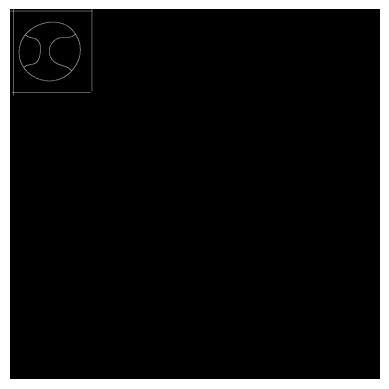

Filtered pixel data saved to ../master_folder/utils/output/out_csv/pixel_data-frag0.csv.


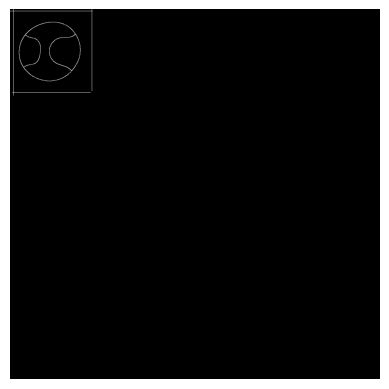

Filtered pixel data saved to ../master_folder/utils/output/out_csv/pixel_data-frag1.csv.


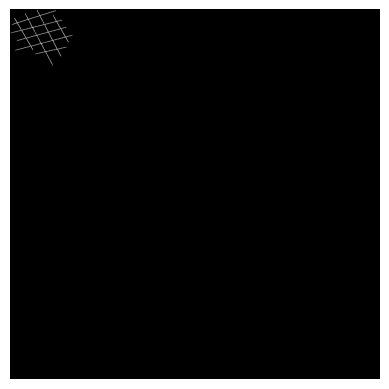

Filtered pixel data saved to ../master_folder/utils/output/out_csv/pixel_data-frag2.csv.


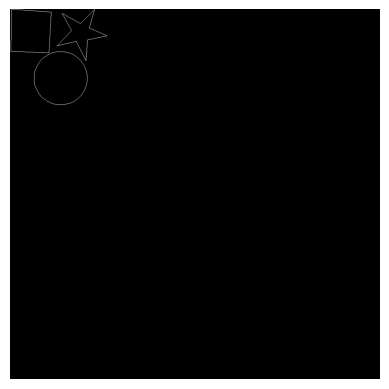

Filtered pixel data saved to ../master_folder/utils/output/out_csv/pixel_data-isolated.csv.


In [47]:
if __name__ == '__main__':
    execute("frag0")
    execute("frag1")
    execute("frag2")
    execute("isolated")